# Chignolin clustering based on MFPT
Author: ernesto.suarez.a [at] gmail.com

This is a modification of the notebook given Chris (christoph.wehmeyer@fu-berlin.de), in this case we are going to use is to cluster the microstates based on the commute times.

In [1]:
import sys
import math
sys.path.append("/home/Ernesto/Dropbox/workspace/NMpathAnalysis")
sys.path.append("/home/Ernesto/Dropbox/workspace/NMpathAnalysis/nmpath")
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import*
from clustering import *

# Print 
from IPython.display import Markdown, display

## Auxiliary functions


In [2]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()

## Create a feature reader

We create a feature reader to obtain minimal distances between all residues which are not close neighbours. Feel free to map these distances to binary contacts or use inverse minimal residue distances instead. These coices usually work quite well.

In [3]:
traj_files = [f for f in sorted(glob('CLN025-0-protein/CLN025-0-protein-*.dcd'))]
pdb_file = 'CLN025-0-protein/chig_pdb_166.pdb'

features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

11-07-17 12:37:42 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


/home/esuarez/anaconda3/lib/python3.6/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.2.
  .format(latest=latest, current=current), category=UserWarning)


## RMSD

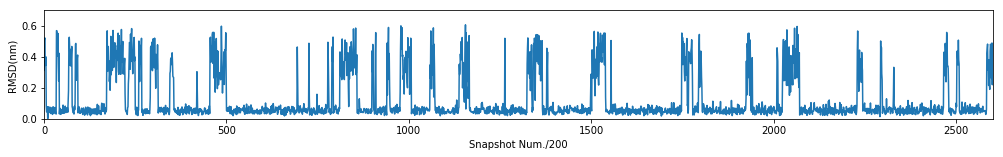

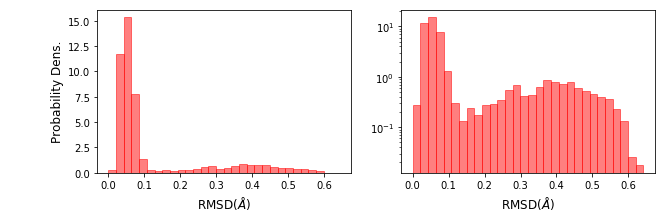

In [4]:
reference = md.load_dcd("CLN025-0-protein/CLN025-0-protein-000.dcd", top=pdb_file)

CA_atoms = reference.topology.select('name CA and resid 1 to 8')

rmsd = []

for traj_name in traj_files:
    traj = md.load_dcd(traj_name, top=pdb_file)
    for element in md.rmsd(traj,reference,2000, atom_indices=CA_atoms):
        rmsd.append(element)

fig =plt.figure(figsize = (17,2))
plt.plot(rmsd[::200])
plt.axis([0,2600, 0.0, 0.7])
plt.ylabel("RMSD(nm)")
plt.xlabel("Snapshot Num./200")
plt.show()

fig =plt.figure(figsize = (10,3))

ax1 = fig.add_subplot(121)
ax1.hist(rmsd[::100],normed=True, bins=30, color="r", 
         alpha=0.5, edgecolor="r")
ax1.set_xlabel("RMSD$(\AA)$",fontsize=12)
ax1.set_ylabel("Probability Dens.",fontsize=12)


ax2 = fig.add_subplot(122)
ax2.hist(rmsd[::100],normed=True, bins=30, color="r", 
         alpha=0.5, edgecolor="r")
ax2.set_xlabel("RMSD$(\AA)$",fontsize=12)
ax2.set_yscale("log")
ax2.annotate("Log scale",xy=(0.3,30))
plt.show()

rmsd = np.array(rmsd)*10.0  # to Angstrom

## Discretization and MSM estimation

We start the actual analysis with a TICA projection onto two components on which we perform a k-means clustering. Then, we take a quick view on the implied timescale convergence, the 2D representation, and the clustering:

11-07-17 12:39:18 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Algorithm did not reach convergence criterion of 1e-05 in 100 iterations. Consider increasing max_iter.


/home/esuarez/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


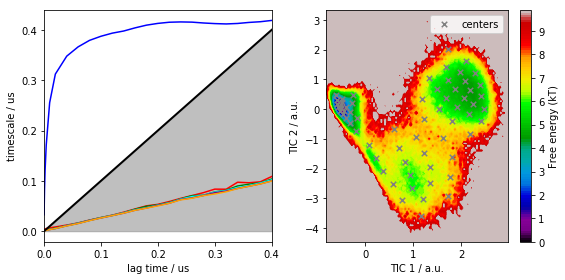

In [5]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=64, max_iter=100)
#print(cluster.dtrajs)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

# MSM estimation
msm = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lags]

## Agglomerative Clustering from the transition matrix

Hierarchical agglomerative clustering using the Markovian commute time: $t_{ij} = \mathrm{MFPT}(i \rightarrow j)+ \mathrm{MFPT}(j \rightarrow i)$.

We follow some rules to build (in every mergin step) a new set of transition probabilities $\{k_{i,j}\}$, defined with the same lag-time $\tau$. After merging two states $l$ and $m$, the probability of the transitions entering the new state that we will call "$lm$", from any state $i$, is computed as


$$k_{i,ml}=k_{i,m}+k_{i,l}$$


On the other hand the transition probabilities from $ml$ to any other state $j$ is computed as 


$$k_{ml,j}=\frac{p_m k_{m,j}+p_l k_{l,j}}{p_m+p_l}$$


Similarly,

$$k_{ml,ml}=\frac{p_m (k_{m,m}+k_{m,l})+p_l (k_{l,l}+k_{l,m})}{p_m+p_l}$$


### Lag times to use

In [6]:
lag_to_use = [1, 10, 100, 1000]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

# This are the t_cut intervals to explore (in lag-time units) with the lag times in "lag_to_use"
range_per_lag = [[175,525], [150,320], [180,250], [50,200]]

### Clustering

### Lag-time: 0.2ns

#### t_values:

t_cut: 35.00ns, t_min: 37.79043957171201, t_max: 3.81e+02ns, tAB: 0.00ns


/home/esuarez/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


t_cut: 39.60ns, t_min: 41.542914869848886, t_max: 3.78e+02ns, tAB: 212.07ns
t_cut: 44.20ns, t_min: 45.42228510100576, t_max: 3.45e+02ns, tAB: 212.06ns
t_cut: 48.80ns, t_min: 50.949943447051666, t_max: 3.44e+02ns, tAB: 212.06ns
t_cut: 53.40ns, t_min: 68.06778733594066, t_max: 3.42e+02ns, tAB: 212.04ns
t_cut: 58.00ns, t_min: 68.06778733594066, t_max: 3.42e+02ns, tAB: 212.04ns
t_cut: 62.60ns, t_min: 68.06778733594066, t_max: 3.42e+02ns, tAB: 212.04ns
t_cut: 67.20ns, t_min: 68.06778733594066, t_max: 3.42e+02ns, tAB: 212.04ns
t_cut: 71.80ns, t_min: 73.91948648122052, t_max: 3.42e+02ns, tAB: 212.04ns
t_cut: 76.40ns, t_min: 83.54627593141534, t_max: 3.41e+02ns, tAB: 212.03ns
t_cut: 81.00ns, t_min: 83.54627593141534, t_max: 3.41e+02ns, tAB: 212.03ns
t_cut: 85.60ns, t_min: 89.87211744772831, t_max: 2.93e+02ns, tAB: 200.23ns
t_cut: 90.20ns, t_min: 93.65502443321859, t_max: 2.93e+02ns, tAB: 200.22ns
t_cut: 94.80ns, t_min: 94.95898352422921, t_max: 2.77e+02ns, tAB: 0.00ns
t_cut: 99.40ns, t_min: 12

#### Observed clusters vs t_cut

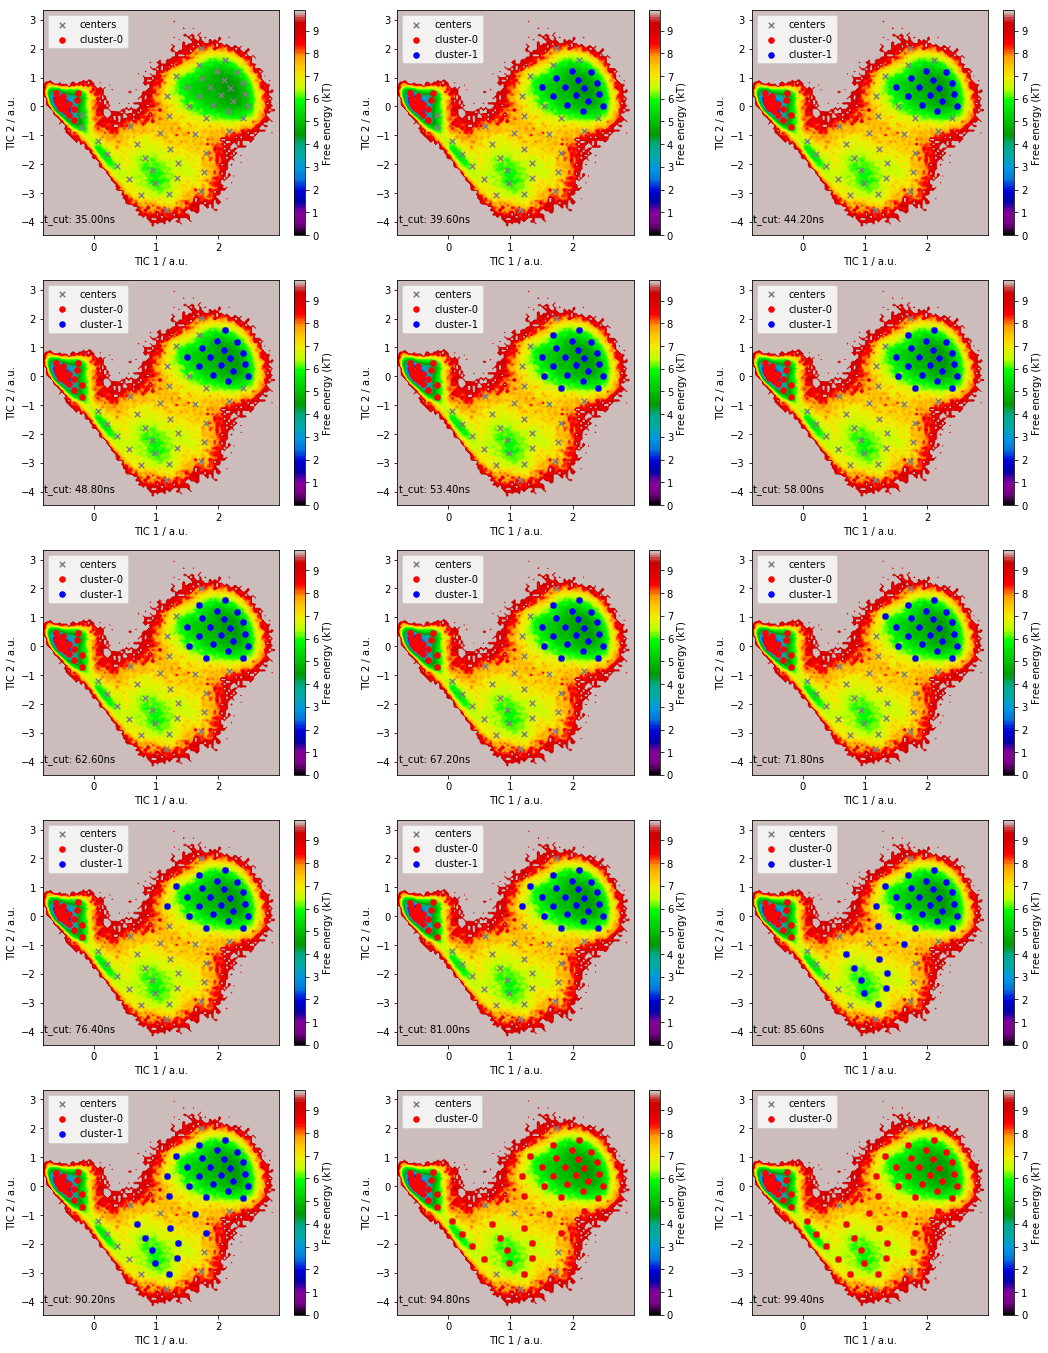

#### t_AB plots:

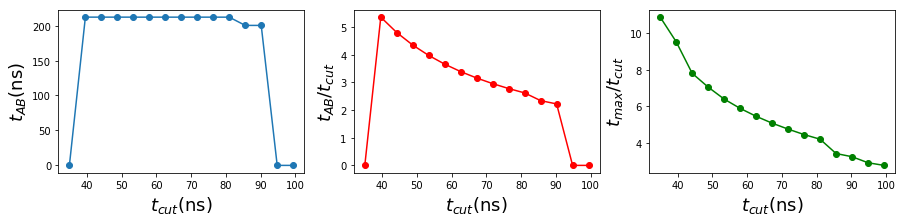

#### RMSD of the Macrostates:

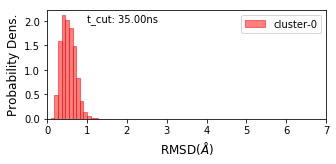

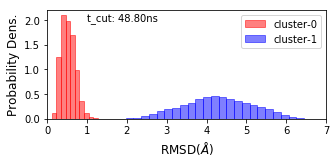

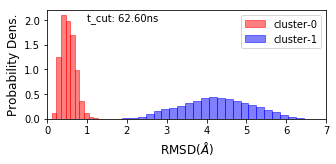

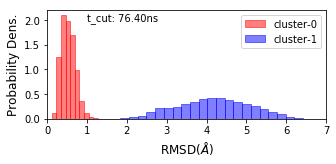

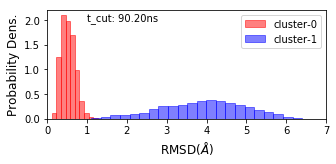

### Lag-time: 2.0ns

#### t_values:

t_cut: 300.00ns, t_min: 328.3940106776951, t_max: 2.53e+03ns, tAB: 0.00ns
t_cut: 322.00ns, t_min: 328.3940106776951, t_max: 2.53e+03ns, tAB: 0.00ns
t_cut: 344.00ns, t_min: 372.026285847605, t_max: 2.53e+03ns, tAB: 0.00ns
t_cut: 366.00ns, t_min: 372.026285847605, t_max: 2.53e+03ns, tAB: 0.00ns
t_cut: 388.00ns, t_min: 409.5656821635408, t_max: 2.53e+03ns, tAB: 1727.46ns
t_cut: 410.00ns, t_min: 461.40097665980164, t_max: 2.52e+03ns, tAB: 1727.46ns
t_cut: 432.00ns, t_min: 461.40097665980164, t_max: 2.52e+03ns, tAB: 1727.46ns
t_cut: 454.00ns, t_min: 461.40097665980164, t_max: 2.52e+03ns, tAB: 1727.46ns
t_cut: 476.00ns, t_min: 504.0496707492766, t_max: 2.52e+03ns, tAB: 1727.42ns
t_cut: 498.00ns, t_min: 504.0496707492766, t_max: 2.52e+03ns, tAB: 1727.42ns
t_cut: 520.00ns, t_min: 529.769135008848, t_max: 2.50e+03ns, tAB: 1724.46ns
t_cut: 542.00ns, t_min: 581.576770293681, t_max: 2.49e+03ns, tAB: 1719.64ns
t_cut: 564.00ns, t_min: 581.576770293681, t_max: 2.49e+03ns, tAB: 1719.64ns
t_cut: 586.00

#### Observed clusters vs t_cut

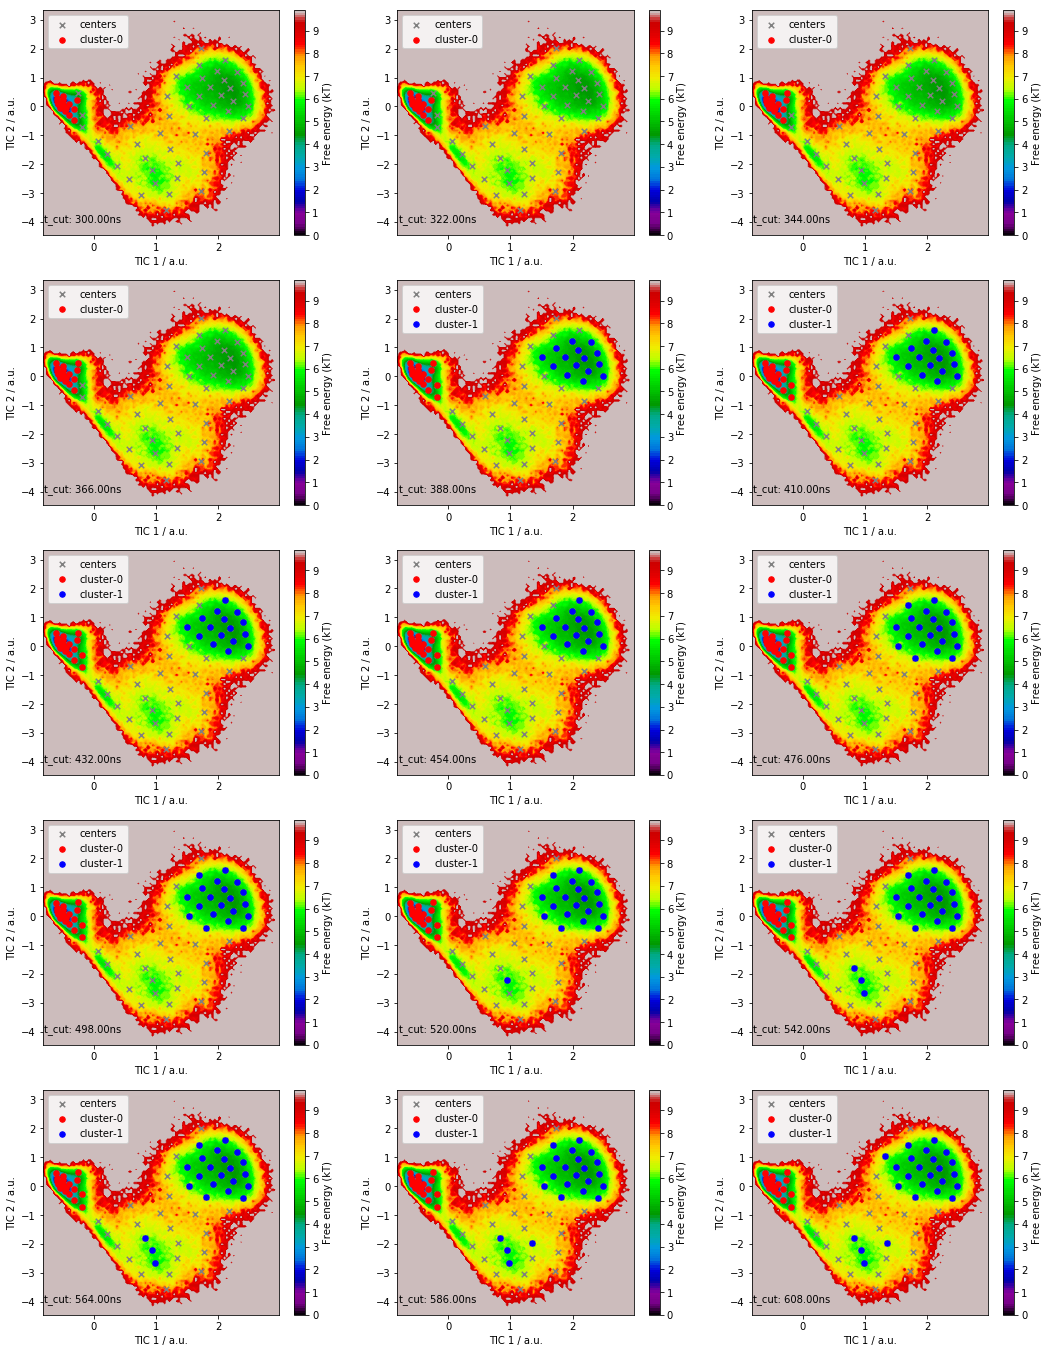

#### t_AB plots:

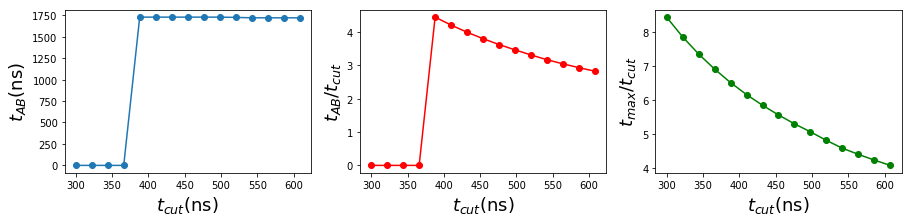

#### RMSD of the Macrostates:

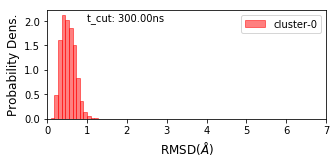

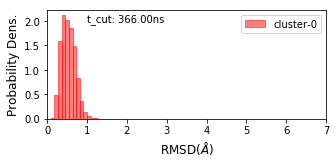

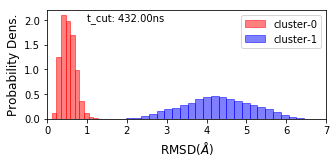

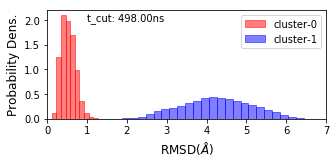

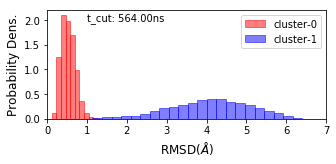

### Lag-time: 20.0ns

#### t_values:

t_cut: 3600.00ns, t_min: 3673.675669171143, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 3680.00ns, t_min: 3711.593983480286, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 3760.00ns, t_min: 3932.78438249266, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 3840.00ns, t_min: 3932.78438249266, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 3920.00ns, t_min: 3932.78438249266, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4000.00ns, t_min: 4245.252416718452, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4080.00ns, t_min: 4245.252416718452, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4160.00ns, t_min: 4245.252416718452, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4240.00ns, t_min: 4245.252416718452, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4320.00ns, t_min: 4481.978749643335, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4400.00ns, t_min: 4481.978749643335, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4480.00ns, t_min: 4481.978749643335, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4560.00ns, t_min: 4615.8090959098945, t_max: 2.36e+04ns, tAB: 0.00ns
t_cut: 4640.00ns, t_min: 51

#### Observed clusters vs t_cut

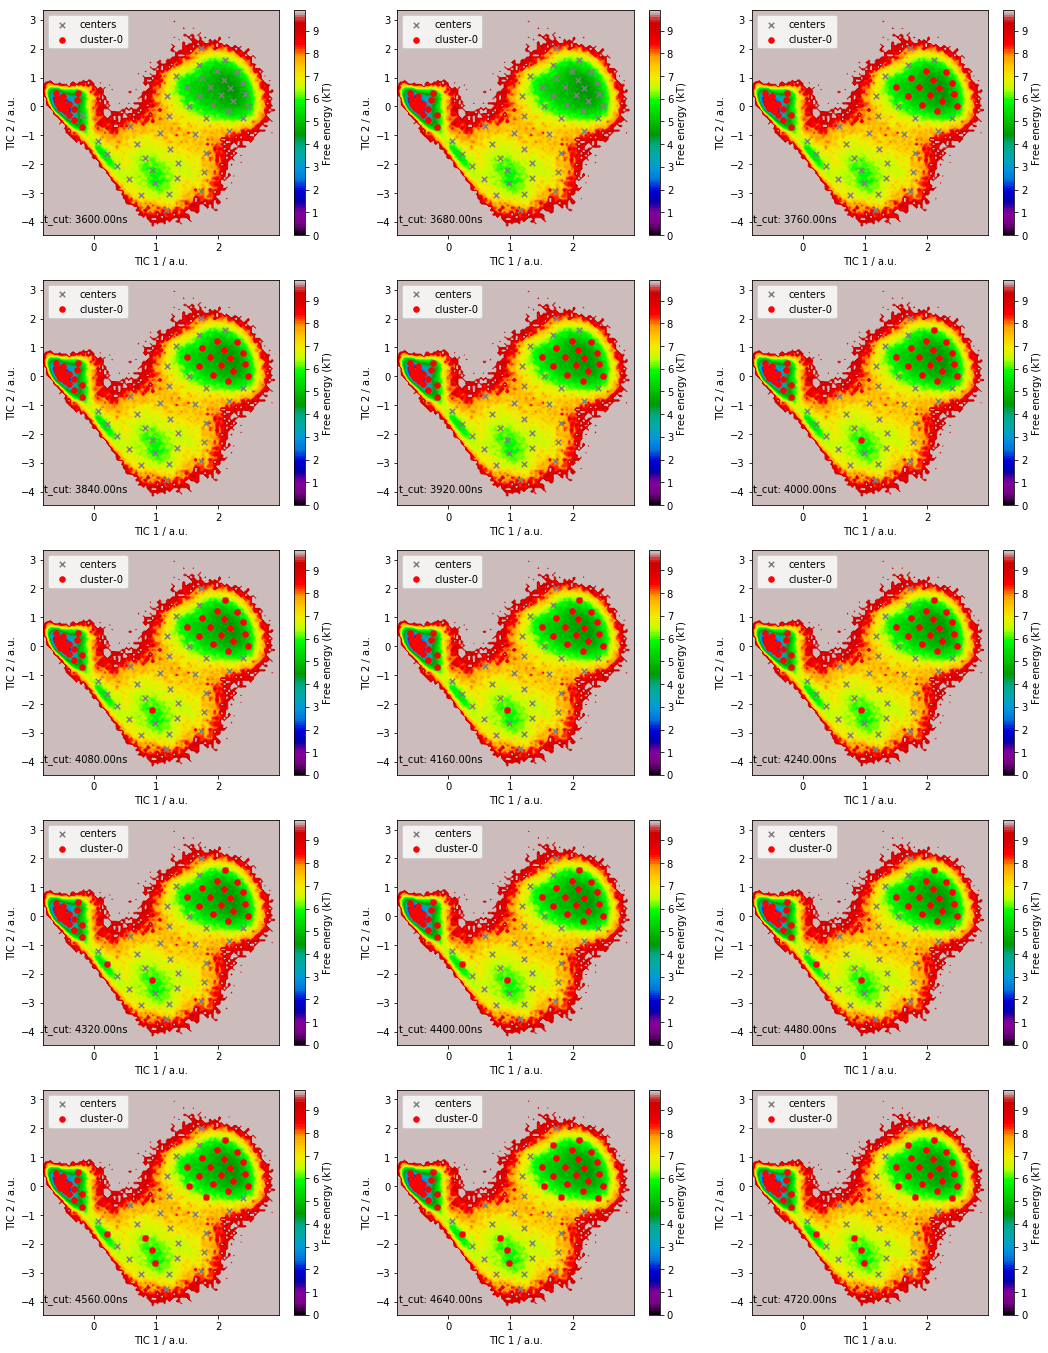

#### t_AB plots:

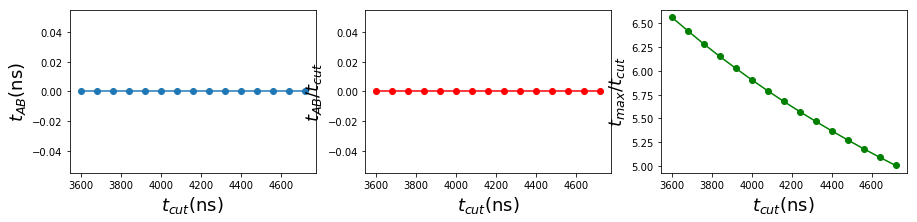

#### RMSD of the Macrostates:

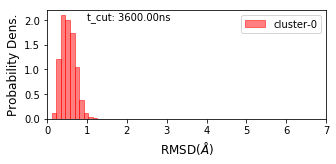

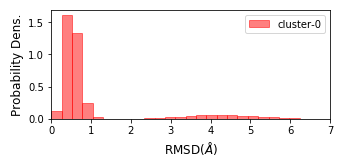

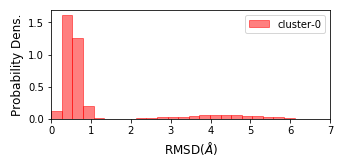

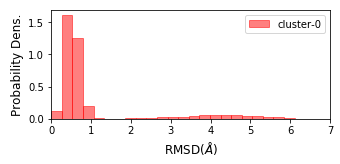

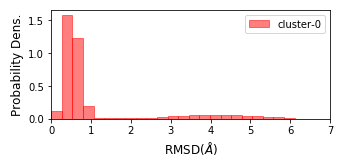

### Lag-time: 200.0ns

#### t_values:

t_cut: 10000.00ns, t_min: 10284.47333719151, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 12000.00ns, t_min: 12082.916881743271, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 14000.00ns, t_min: 14388.245754703186, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 16000.00ns, t_min: 21102.124363769817, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 18000.00ns, t_min: 21102.124363769817, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 20000.00ns, t_min: 21102.124363769817, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 22000.00ns, t_min: 22953.324292212932, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 24000.00ns, t_min: 24015.95004481684, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 26000.00ns, t_min: 27634.344444290975, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 28000.00ns, t_min: 29051.152014442112, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 30000.00ns, t_min: 30717.874014156154, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 32000.00ns, t_min: 32486.899382702177, t_max: 2.40e+05ns, tAB: 0.00ns
t_cut: 34000.00ns, t_min: 35433.63225407854, t_max: 2.40e+05ns, tAB: 0.00ns
t_

#### Observed clusters vs t_cut

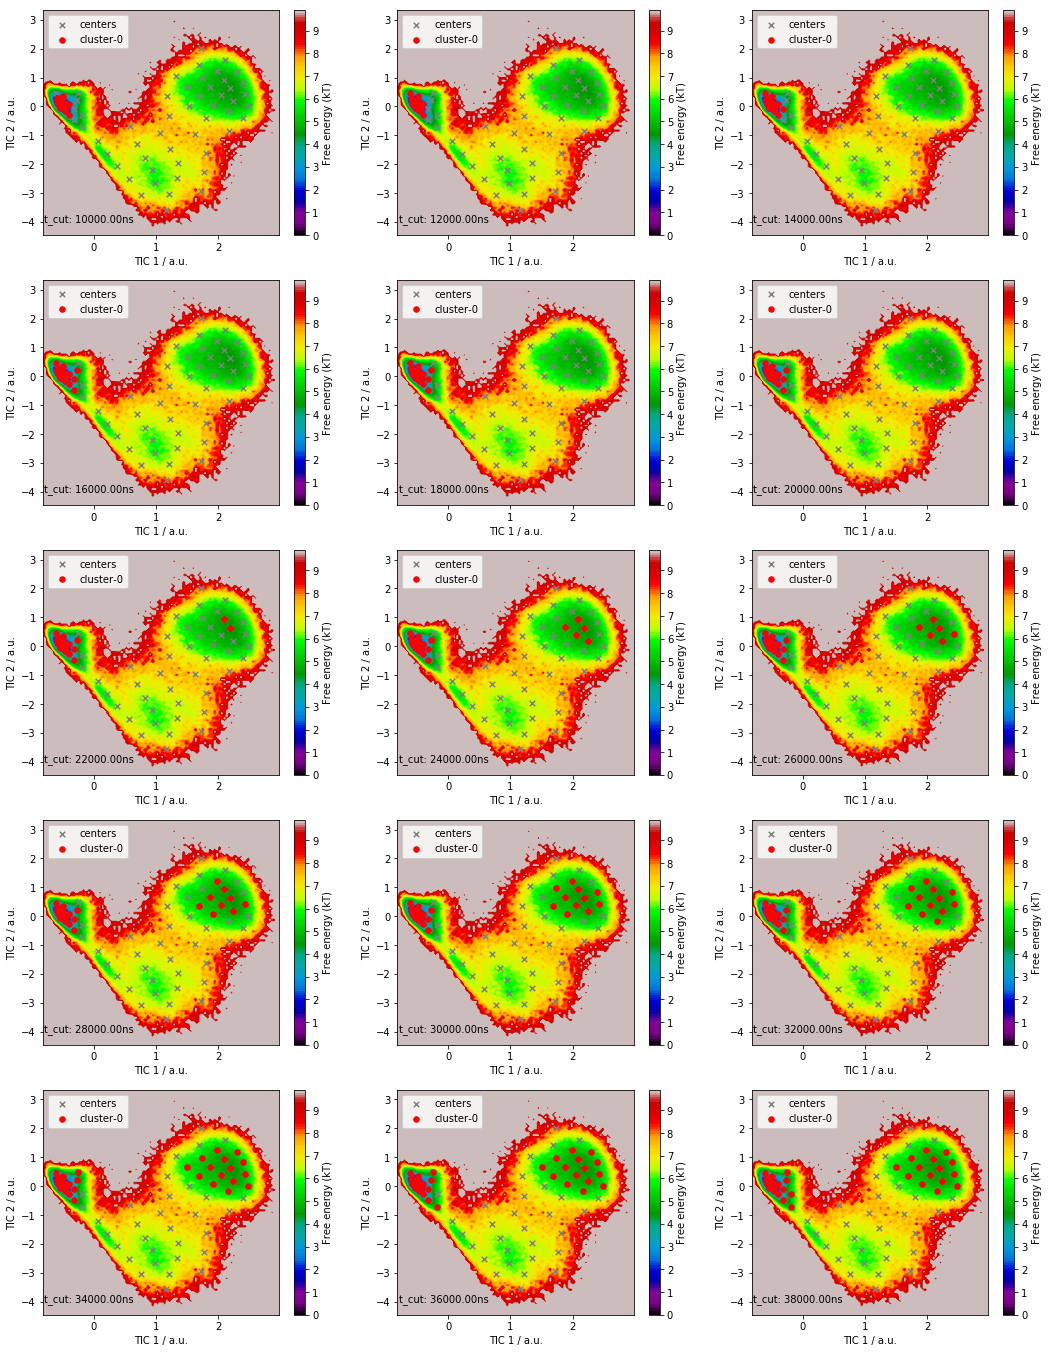

#### t_AB plots:

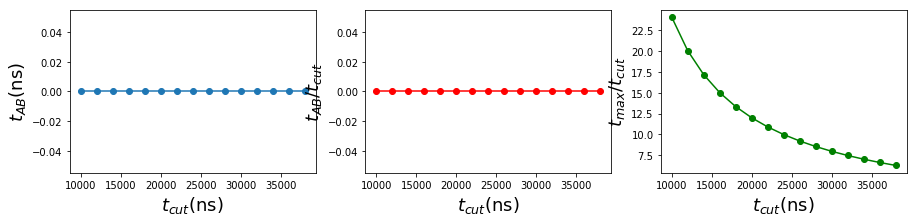

#### RMSD of the Macrostates:

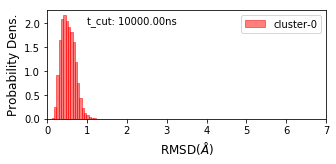

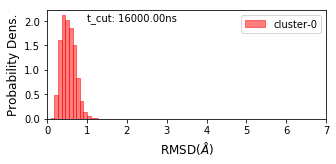

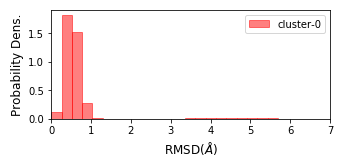

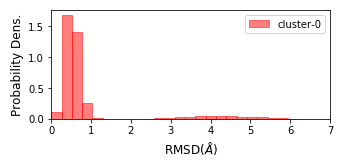

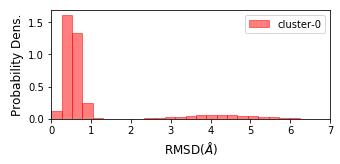

In [7]:
for k, index in enumerate(lag_index):
    K = msm[index].P
    dt = 0.2*lags[index]
    #---------------------
    printmd("### Lag-time: "+str(dt)+"ns")

    t_min_list=[]
    t_max_list=[]
    t_AB_list=[]

    big_clusters_list = []

    # t_cut range
    min_ = range_per_lag[k][0]
    max_ = range_per_lag[k][1]
    interval = (max_ - min_)//15 
    t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


    fig_n_cols = 3
    fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


    fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

    printmd("#### t_values:")
    for ii, t_cut in enumerate(t_cut_values):

        big_clusters=[]
        big_clusters_index =[]

        # clustering
        clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)

        t_min_list.append(t_min)
        t_max_list.append(t_max)

        for i, cluster_i in enumerate(clusters):
            if len(cluster_i) > 1:
                big_clusters.append(cluster_i)
                big_clusters_index.append(i)

        n_big = len(big_clusters)

        macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
        #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
        big_clusters_list.append(big_clusters)

        if n_big > 1:
            tAB = markov_commute_time(clustered_tmatrix,[macrostates[0]],[macrostates[1]] )
        else:
            tAB = 0.0
        t_AB_list.append(tAB)

        print("t_cut: {:.2f}ns, t_min: {}, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

        plt.subplot(fig_n_rows, fig_n_cols, ii+1)
        pyemma.plots.plot_free_energy(*tica.T)
        plt.scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
        plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

        colors = ['red','blue','green','black','orange']

        for i, cluster_i in enumerate(big_clusters):
            cluster_i_tica_xy = []
            for index in cluster_i:
                cluster_i_tica_xy.append(cluster.clustercenters[index])
            cluster_i_tica_xy = np.array(cluster_i_tica_xy)
            plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

        plt.legend(loc='upper left')
        plt.xlabel('TIC 1 / a.u.')
        plt.ylabel('TIC 2 / a.u.')
    printmd("#### Observed clusters vs t_cut")
    plt.show()

    printmd("#### t_AB plots:")
    plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

    printmd("#### RMSD of the Macrostates:")
    plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs=cluster.dtrajs)